# Using an LLM to Summarize and Make Embeddings

In [21]:
from langchain_openai import AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough# Practice Using an LLM to Chunk and Summarize Data

from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_openai import AzureOpenAIEmbeddings

from azure.identity import (
    DefaultAzureCredential,
)

from azure.identity import AzureAuthorityHosts
from azure.keyvault.secrets import SecretClient

from dotenv import load_dotenv

from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

import os

### Create your Azure OpenAI Resource
_If you have your resource from the last exercise, you don't need to complete the following steps._ **_NOTE: You also need to deploy the text-embedding-ada-002 model for this lab._**

Navigate to the [Azure Portal](https://portal.azure.com/#home) or [US Gov Azure Portal](https://portal.azure.us/#home) and login using your account. Next you're going to create an Azure OpenAI resource, create a new resource group and use any unique name for the resource's name.  
Once the resource is created, you need to open [Azure AI Foundry](https://ai.azure.com/) or [Azure OpenAI Studio](https://ai.azure.us/) to deploy the model. Navigate to deployments, press deploy model and select gpt-35-turbo-instruct.  Make sure to increase your rate limit, or tokens per minute (around 700k should be sufficient).

In [22]:
load_dotenv()

credential = DefaultAzureCredential(authority=AzureAuthorityHosts.AZURE_GOVERNMENT)

secret_client = SecretClient(vault_url=os.getenv('KEY_VAULT_URL'), credential=credential)
deployment = os.getenv('DEPLOYMENT')
endpoint_url = os.getenv('AZURE_OPENAI_ENDPOINT')
api_version = os.getenv('API_VERSION')
api_key = secret_client.get_secret(os.getenv('SECRET_NAME')).value


azure_client = AzureChatOpenAI(
                api_key=api_key
                ,api_version=api_version
                ,azure_endpoint=endpoint_url
                ,deployment_name=deployment
                ,temperature=0
                ,max_tokens=4000
                #,model_kwargs={"response_format": {"type": "json_object"}}
)

In [23]:
loader = PyPDFLoader("data/lotr.pdf")

pages = loader.load_and_split()

### Chunking and Embedding the Data

Similar to last time, we need to chunk the data, but this time we will also use an embedding model. Embeddings are numerical representations of text that capture semantic meaning. They allow computers to understand the relationship between words and phrases. The text-embedding-ada-002 model is OpenAI's latest generation of a text embedding model. It has 1536 dimensions and can process 8191 tokens.

In [24]:
prologue_pages = pages[24:39]
# Python for loop in one line
prologue_text = ''
for page in prologue_pages : prologue_text += page.page_content

In [25]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, for demonstration.
    chunk_size = 800,
    chunk_overlap  = 80
)

docs = text_splitter.create_documents([prologue_text])
print(len(docs))

53


In [26]:
embedding_model = os.getenv('EMBEDDING_DEPLOYMENT')

embeddings = AzureOpenAIEmbeddings(
    api_key=api_key,
    azure_endpoint=endpoint_url,
    azure_deployment=embedding_model,
    openai_api_version=api_version,
)

In [27]:
vectors = embeddings.embed_documents([doc.page_content for doc in docs])

### What is t-SNE?

t-SNE is a nonlinear dimensionality reduction technique that allows high-dimensional data to be visualized in 2 or 3 dimensions. Since we used the ada-embedding to create a vector embedding, we are going to reduce the 1536 dimensions to 2 so that we can visualize it later on.

In [28]:
from sklearn.manifold import TSNE

import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce from 1536 dimension to 2 dimensions
tsne = TSNE(n_components=2, perplexity=5, random_state=12)

vectors = np.array(vectors)
reduced_data_tsne = tsne.fit_transform(vectors)

### `calculateSilhouetteAvg`

In the next function we are calculating the average silhouette score. A silhouette score is a metric that is used to evaluate the quality of clustering results in data clustering. It ranges from -1 to +1, where positive values indicate good clustering, zero indicates overlapping clusters or data points equally close to multiple clusters, and  negative values indicate poor clustering.  

First, to cluster the data we are going to use the K-means method, which is an unsupervised machine learning algorithm used to group similar data points into clusters based on their features. You partition the data into k number of clusters, hence the name.

### `getBestClusteringResult`

In the next function, we are taking the best result from the average silhouette scores, calculated by `CalculateSilhouetteAvg`

In [29]:
def calculateSilhouetteAvg(num_clusters, data):
    simplefilter(action='ignore', category=FutureWarning)
    simplefilter(action='ignore', category=Warning)
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(data)

    labels = kmeans.labels_

    matrix = np.vstack(vectors)
    matrix.shape

    sample_silhouette_values = metrics.silhouette_samples(matrix, labels)

    means_lst = []
    for label in range(num_clusters):
        means_lst.append(sample_silhouette_values[labels == label].mean())
    
    return (num_clusters, sum(means_lst) / len(means_lst) , labels)

In [30]:
def getBestClusteringResult(data):
    best_result = None
    for i in range(4,20):
        result = calculateSilhouetteAvg(i, data)
        print(result)
        if best_result is None or result[1] > best_result[1]:
            best_result = result
    
    return best_result

In [31]:
final = getBestClusteringResult(reduced_data_tsne)

(4, 0.06511134754977833, array([3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0,
       0, 0, 0, 3, 2, 2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 1, 1, 1, 3, 3, 3, 3]))
(5, 0.07740443848243823, array([4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2,
       2, 2, 2, 4, 0, 0, 0, 0, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3]))
(6, 0.10763980910453226, array([4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3,
       3, 3, 3, 5, 0, 0, 0, 0, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       5, 2, 2, 2, 2, 2, 2, 2, 2]))
(7, 0.11374284938025016, array([6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 6, 2,
       2, 2, 2, 1, 5, 5, 5, 5, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 4, 4, 4, 4, 4, 4, 4, 4]))
(8, 0.09467545603078281, array([1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4,
       4, 4, 4, 6, 3, 3, 3, 3, 6, 1, 7, 7, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7,
 

Since we reduced our data earlier by performing t-SNE, we can visualzie the clusters below. As you can see, we have 5 distinct clusters.

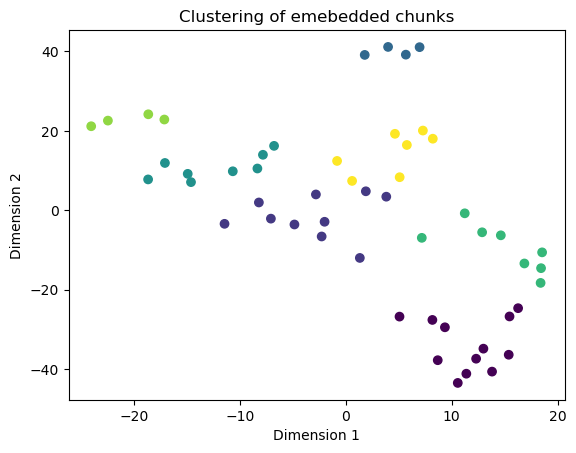

In [32]:
# Plot the reduced data
import matplotlib.pyplot as plt
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=final[2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of emebedded chunks')
plt.show()

In [33]:
final_labels = final[2]

In [34]:
print(len(docs), len(final_labels))

53 53


Below we have a dataframe of our 53 chunks, and what group they are clustered into. There are 5 unique labels (clusters)

In [35]:
data =  [(doc.page_content, label) for doc, label in zip(docs, final_labels)]

df = pd.DataFrame(data, columns=['doc', 'label'])
df

,doc,label
0,"3 PR OL OGU E \namong them, but there remained...",6
1,they later undertook the hard and perilous cro...,6
2,larger; and they preferred ﬂat lands and river...,6
3,and were less shy of Men. They came west after...,6
4,leaders or chieftains among clans of Harfoots ...,6
5,their earlier settlements had long disappeared...,1
6,"to Gondor, and about all the coasts of the Sea...",1
7,"Kingdom, and they took all the land beyond to ...",1
8,"line, which came to an end with Arvedui three ...",1
9,thousand years they were little troubled by wa...,1


In [36]:
print(df["label"].unique())
distinct_labels = df["label"].unique()

[6 1 3 2 5 0 4]


### Prompting the LLM

Like the last chunking notebook, we will prompt the LLM to create summaries from each chunk.

In [37]:
prompt = PromptTemplate(
    template="""
### Instructions:
Summarize the text in narrative form. 
Your summary will be added to other summaries so do not give an introduction to the summary, assume the reader has context for what you are telling them. 
### Text:\n {text}"""
    ,input_variables=["text"]
)

In [38]:
chain = (
    {"text": RunnablePassthrough()} 
        | prompt
        | azure_client
        | StrOutputParser()
    )

In [39]:
def sumarizeText(chain, text):
    return chain.invoke(text)

Instead of keeping the summaries in chronological order of the text, we are going to order it by its cluster. Label 0 summaries first, then 1, 2... etc. This way, the summaries are put by the theme of the topic, from the clustering we performed before, which is why it is a semantic summary. 

In [40]:
summary = []
for i in distinct_labels:
    rows = df.loc[df["label"] == i]
    text = rows["doc"].tolist()
    summary.append(sumarizeText(chain, text))

print(' '.join(summary))

In the distant past, Hobbits, like many other folk, migrated westward, with their earliest legends hinting at a time when they lived in the upper vales of Anduin, near Greenwood the Great and the Misty Mountains. Their accounts suggest that they crossed the mountains into Eriador due to the increasing presence of Men and the encroaching darkness of Mirkwood. By this time, Hobbits had already diversified into three distinct breeds: Harfoots, Stoors, and Fallohides. The Harfoots were the most numerous, characterized by their smaller stature and preference for highlands, while the Stoors were broader and favored flat lands. The Fallohides, being the least numerous, were taller and more adventurous, often mingling with Elves and taking on leadership roles among the other Hobbit clans.

As the Hobbits settled in Eriador, they encountered remnants of the Dúnedain, the kings of Men, whose numbers were dwindling. This allowed the Hobbits to establish their own communities, although many of the

In [41]:
with open("./prologue_semantic_summary_text.txt", "w") as semantic_sum:
    # Writing data to a file
    semantic_sum.write(' '.join(summary))